# AutoShorts 모듈별 테스트 노트북

각 Agent를 개별적으로 테스트하고 프롬프트를 확인할 수 있습니다.

## 📋 필요한 API 키

`.env` 파일에 다음 키들을 설정하세요:

```bash
# 필수
OPENAI_API_KEY=sk-...           # GPT-4o-mini (플롯 생성)
REDIS_URL=redis://localhost:6379

# 권장
ELEVENLABS_API_KEY=...          # ElevenLabs (음성+음악 생성, $5/월~)
GEMINI_API_KEY=...              # Gemini 2.5 Flash Image (나노바나나, 이미지 생성)

# 선택 (없으면 Stub 모드로 동작)
COMFYUI_URL=http://localhost:8188  # ComfyUI (이미지 생성, 로컬 무료)
MUBERT_LICENSE=...              # Mubert (음악 폴백, $14/월~, deprecated)
PLAYHT_USER_ID=...              # PlayHT (음성 대체, $31/월~)
PLAYHT_API_KEY=...
```

**비용 최적화 팁:**
- ElevenLabs 하나로 음성+음악 모두 생성 가능 ($5/월 플랜)
- Gemini API로 이미지 생성 (나노바나나, $0.039/이미지)
- Mubert는 비쌈 ($14/월), ElevenLabs로 대체 권장
- ComfyUI는 로컬 실행 시 무료 (GPU 필요)

## 🚀 실행 전 체크리스트

1. Redis 서버 실행: `redis-server`
2. ComfyUI 실행 (선택): `cd ComfyUI && python main.py`
3. 가상환경 활성화: `source kvenv/bin/activate`
4. 필요한 패키지 설치 확인: `pip install -r backend/requirements.txt`

## 0. 환경 설정

In [21]:
!pip install -r backend/requirements.txt


[notice] A new release of pip is available: 24.0 -> 25.3
[notice] To update, run: pip install --upgrade pip


In [22]:
# Python path 설정 (backend 모듈 import 가능하도록)
import sys
from pathlib import Path

backend_path = Path.cwd() / "backend"
if str(backend_path) not in sys.path:
    sys.path.insert(0, str(backend_path))

print(f"✅ Python path 설정 완료: {backend_path}")

✅ Python path 설정 완료: /Users/yuli/Documents/01.AI_Workspace/Kurz_Studio_AI/backend


In [23]:
# 필요한 모듈 import
import json
from datetime import datetime
from pathlib import Path

print("✅ 기본 모듈 import 완료")

✅ 기본 모듈 import 완료


In [24]:
# API 키 확인
from app.config import settings

print("=" * 50)
print("API 키 상태 확인")
print("=" * 50)

api_status = {
    "OpenAI (플롯 생성)": "✅" if settings.OPENAI_API_KEY else "❌",
    "Gemini (이미지 - 나노바나나)": "✅" if settings.GEMINI_API_KEY else "⚠️  Stub 모드",
    "ComfyUI (이미지 대체)": "✅" if settings.COMFY_URL else "⚠️  Stub 모드",
    "ElevenLabs (음성+음악)": "✅" if settings.ELEVENLABS_API_KEY else "⚠️  Stub 모드",
    "Mubert (음악 폴백)": "✅" if settings.MUBERT_LICENSE else "⚠️  Stub 모드",
    "PlayHT (음성 대체)": "✅" if settings.PLAYHT_API_KEY else "⚠️  Stub 모드",
    "Redis": "✅" if settings.REDIS_URL else "❌",
}

for service, status in api_status.items():
    print(f"{service:30s}: {status}")

print("\n💡 권장 설정:")
print("  - GEMINI_API_KEY: 이미지 생성 (나노바나나, $0.039/이미지)")
print("  - ELEVENLABS_API_KEY: 음성+음악 통합 (저렴, $5/월~)")
print("  - MUBERT_LICENSE: 음악 전용 폴백 (비쌈, $14/월~)")
print("\n⚠️  Stub 모드: API 키가 없으면 더미 데이터 생성")

API 키 상태 확인
OpenAI (플롯 생성)                : ✅
Gemini (이미지 - 나노바나나)          : ✅
ComfyUI (이미지 대체)              : ✅
ElevenLabs (음성+음악)            : ✅
Mubert (음악 폴백)                : ⚠️  Stub 모드
PlayHT (음성 대체)                : ⚠️  Stub 모드
Redis                         : ✅

💡 권장 설정:
  - GEMINI_API_KEY: 이미지 생성 (나노바나나, $0.039/이미지)
  - ELEVENLABS_API_KEY: 음성+음악 통합 (저렴, $5/월~)
  - MUBERT_LICENSE: 음악 전용 폴백 (비쌈, $14/월~)

⚠️  Stub 모드: API 키가 없으면 더미 데이터 생성


## 1. 플롯 생성 테스트 (스키마 v3: characters.json + plot.json → layout.json)

GPT-4o-mini를 사용하여:
1. **캐릭터 정의 생성** (characters.json): 외형, 성격, seed
2. **플롯 생성** (plot.json): 씬별 대사, 표정, 포즈
3. **JSON 변환** (layout.json): appearance + expression + pose 조합

### 스키마 v3 주요 변경사항
- ✅ **캐릭터 정의 분리**: characters.json (재사용 가능)
- ✅ **expression, pose 추가**: 씬별 세밀한 이미지 제어
- ✅ **JSON 형식**: CSV 대신 plot.json 사용 (파싱 문제 해결)
- 🎨 **이미지 생성**: appearance + expression + pose 자동 조합

In [25]:
# 테스트 파라미터 설정
test_prompt = "우주를 여행하는 용감한 고양이의 모험"
num_characters = 2
num_cuts = 5
mode = "story"

# Run ID 생성 (실제와 동일한 형식)
timestamp = datetime.now().strftime("%Y%m%d_%H%M")
prompt_clean = "".join(c for c in test_prompt if not c.isspace())[:8]
run_id = f"{timestamp}_{prompt_clean}"

print(f"Run ID: {run_id}")
print(f"프롬프트: {test_prompt}")
print(f"캐릭터 수: {num_characters}")
print(f"장면 수: {num_cuts}")
print(f"모드: {mode}")

Run ID: 20251105_1841_우주를여행하는용
프롬프트: 우주를 여행하는 용감한 고양이의 모험
캐릭터 수: 2
장면 수: 5
모드: story


In [26]:
# 캐릭터 및 플롯 생성 (스키마 v3)
from app.utils.plot_generator import generate_plot_with_characters

print("=" * 50)
print("GPT-4o-mini에게 전달되는 프롬프트 (2단계)")
print("=" * 50)

# 1단계: 캐릭터 정의 생성
char_system_prompt = f"""당신은 숏폼 영상 콘텐츠의 캐릭터 디자이너입니다.
사용자의 요청에 맞는 {num_characters}명의 캐릭터를 만들어주세요.

각 캐릭터마다 다음 정보를 JSON 형식으로 제공하세요:
- char_id: char_1, char_2, ... 형식
- name: 캐릭터 이름 (창의적으로)
- appearance: 외형 묘사 (이미지 생성에 사용됩니다. 상세하게 작성)
- personality: 성격/특징
- voice_profile: "default" (고정값)
- seed: char_1은 1002, char_2는 1003, ... 순서대로

**중요**:
- 반드시 JSON 형식으로만 출력하세요
- appearance는 이미지 생성 프롬프트로 사용되므로 시각적 특징을 상세히 작성
"""

print("[1단계: 캐릭터 정의 생성]")
print(char_system_prompt[:500] + "...")

# 2단계: 플롯 생성 (JSON 형식)
plot_system_prompt = f"""당신은 숏폼 영상 콘텐츠 시나리오 작가입니다.
사용자의 요청을 {num_cuts}개 장면으로 나누어 {'스토리' if mode == 'story' else '광고 콘텐츠'}를 만들어주세요.

각 장면마다 다음을 포함해야 합니다:
- scene_id: scene_1, scene_2, ... 형식
- char_id: char_1, char_2 (등장인물 ID)
- expression: 표정 (happy, sad, excited, neutral, surprised, angry 등)
- pose: 포즈 (standing, sitting, walking, pointing, jumping 등)
- text: 대사 또는 해설 내용
- text_type: dialogue (대사) 또는 narration (해설)
- emotion: neutral, happy, sad, excited, angry, surprised 중 하나
- subtitle_position: top 또는 bottom
- duration_ms: 장면 지속시간 (보통 4000-6000)

**중요**:
- 반드시 JSON 형식으로만 출력하세요
- expression과 pose는 이미지 생성에 사용됩니다
"""

print("\n[2단계: 플롯 생성 (JSON 형식)]")
print(plot_system_prompt[:500] + "...")

print("\n" + "=" * 50)
print(f"사용자 프롬프트: {test_prompt}")
print("=" * 50)

# 캐릭터 및 플롯 생성 실행
print("\n🔄 캐릭터 및 플롯 생성 중...")
characters_path, plot_json_path = generate_plot_with_characters(
    run_id=run_id,
    prompt=test_prompt,
    num_characters=num_characters,
    num_cuts=num_cuts,
    mode=mode,
)

print(f"\n✅ 캐릭터 JSON 생성 완료: {characters_path}")
print(f"✅ 플롯 JSON 생성 완료: {plot_json_path}")

GPT-4o-mini에게 전달되는 프롬프트 (2단계)
[1단계: 캐릭터 정의 생성]
당신은 숏폼 영상 콘텐츠의 캐릭터 디자이너입니다.
사용자의 요청에 맞는 2명의 캐릭터를 만들어주세요.

각 캐릭터마다 다음 정보를 JSON 형식으로 제공하세요:
- char_id: char_1, char_2, ... 형식
- name: 캐릭터 이름 (창의적으로)
- appearance: 외형 묘사 (이미지 생성에 사용됩니다. 상세하게 작성)
- personality: 성격/특징
- voice_profile: "default" (고정값)
- seed: char_1은 1002, char_2는 1003, ... 순서대로

**중요**:
- 반드시 JSON 형식으로만 출력하세요
- appearance는 이미지 생성 프롬프트로 사용되므로 시각적 특징을 상세히 작성
...

[2단계: 플롯 생성 (JSON 형식)]
당신은 숏폼 영상 콘텐츠 시나리오 작가입니다.
사용자의 요청을 5개 장면으로 나누어 스토리를 만들어주세요.

각 장면마다 다음을 포함해야 합니다:
- scene_id: scene_1, scene_2, ... 형식
- char_id: char_1, char_2 (등장인물 ID)
- expression: 표정 (happy, sad, excited, neutral, surprised, angry 등)
- pose: 포즈 (standing, sitting, walking, pointing, jumping 등)
- text: 대사 또는 해설 내용
- text_type: dialogue (대사) 또는 narration (해설)
- emotion: neutral, happy, sad, excited, angry, surprised 중 하나
- subtitle_position: top 또는 bottom
- duration_ms: 장면 지속시간 (보통 4000-6000)

**중요**:
- 반드시 ...

사용자 프롬프트: 우주를 여행하는 용감한 고양이의 모험

🔄 캐릭터 및 플롯 생성 중..

In [27]:
# 생성된 파일 확인 (스키마 v3)
import pandas as pd
import json

print("=" * 50)
print("1. 생성된 characters.json 내용")
print("=" * 50)

with open(characters_path, "r", encoding="utf-8") as f:
    characters_data = json.load(f)

for char in characters_data["characters"]:
    print(f"\n[{char['char_id']}] {char['name']}")
    print(f"  외형: {char['appearance']}")
    print(f"  성격: {char['personality']}")
    print(f"  음성: {char['voice_profile']}")
    print(f"  Seed: {char['seed']}")

print("\n" + "=" * 50)
print("2. 생성된 plot.json 내용 (v3 스키마)")
print("=" * 50)

# Read plot.json
with open(plot_json_path, "r", encoding="utf-8") as f:
    plot_data = json.load(f)

# Convert scenes to dataframe for display
df = pd.DataFrame(plot_data["scenes"])
print(df.to_string())

print(f"\n총 {len(plot_data['scenes'])}개 장면 생성됨")

print("\n" + "=" * 50)
print("스키마 v3 특징")
print("=" * 50)
print("✅ characters.json: 캐릭터 외형 및 설정 (appearance, personality, seed)")
print("✅ plot.json: 장면별 표정/포즈 제어 (expression, pose)")
print("✅ char_name 제거: characters.json에서 char_id로 참조")
print("✅ 이미지 생성: appearance + expression + pose 조합")

1. 생성된 characters.json 내용

[char_1] 코스모캣
  외형: 우주복을 입은 고양이로, 반짝이는 별들이 박힌 푸른색 우주복을 착용하고 있다. 귀는 뾰족하고, 눈은 큰 보라색으로 빛나며, 털은 은색으로 빛난다. 우주복의 헬멧은 투명하게 되어 있어 고양이의 표정을 잘 볼 수 있다. 발에는 우주선의 제어 장치처럼 생긴 장비가 달려있고, 꼬리는 우주선의 후미를 연상시키는 회오리 모양이다.
  성격: 용감하고 호기심이 많은 성격으로, 새로운 별과 행성을 탐험하는 것을 좋아한다. 친구들에게는 언제나 충실하고, 어려운 상황에서도 긍정적인 태도를 잃지 않는다. 가끔은 고집이 세지만, 항상 모험을 즐기며 친구들을 지키려는 마음이 강하다.
  음성: default
  Seed: 1002

[char_2] 네뷸라
  외형: 우주에서 온 신비로운 고양이로, 털은 깊은 우주를 연상시키는 짙은 파랑과 보라색 그라데이션으로 이루어져 있다. 눈은 은하수처럼 반짝이며, 귀 끝이 반짝이는 별처럼 빛난다. 몸에는 작은 은하 모양의 문양이 있으며, 발바닥에는 빛나는 은하수의 흔적이 있다. 우아한 움직임을 자랑하며, 마치 우주를 유영하는 듯한 느낌을 준다.
  성격: 신비롭고 지혜로운 성격으로, 우주에 대한 깊은 지식을 가지고 있다. 친구들에겐 조언자가 되어주며, 이끌어주는 역할을 한다. 감정 표현이 섬세하고, 때때로 신비로운 분위기를 풍기며, 고양이의 특성을 잘 드러낸다. 조용하면서도 강렬한 존재감을 지닌다.
  음성: default
  Seed: 1003

2. 생성된 plot.json 내용 (v3 스키마)
  scene_id char_id expression         pose                   text text_type  emotion subtitle_position  duration_ms
0  scene_1  char_1    excited     standing       안녕! 나는 용감한 고양이야!  dialogue    happy       

In [28]:
# plot.json + characters.json → layout.json 변환 (스키마 v3)
from app.utils.json_converter import convert_plot_to_json

print("🔄 characters.json + plot.json → layout.json 변환 중...")

json_path = convert_plot_to_json(
    plot_json_path=str(plot_json_path),
    run_id=run_id,
    art_style="파스텔 수채화",
    music_genre="ambient",
)

print(f"✅ JSON 생성 완료: {json_path}")

print("\n💡 변환 과정:")
print("  1. characters.json 읽기 → Character 객체")
print("  2. plot.json 읽기 → Scene 객체")
print("  3. 이미지 프롬프트 생성: appearance + expression + pose")
print("  4. layout.json 저장")

🔄 characters.json + plot.json → layout.json 변환 중...
✅ JSON 생성 완료: app/data/outputs/20251105_1841_우주를여행하는용/layout.json

💡 변환 과정:
  1. characters.json 읽기 → Character 객체
  2. plot.json 읽기 → Scene 객체
  3. 이미지 프롬프트 생성: appearance + expression + pose
  4. layout.json 저장


In [29]:
# JSON 내용 확인 (스키마 v4: texts 통합)
with open(json_path, "r", encoding="utf-8") as f:
    layout = json.load(f)

print("=" * 50)
print("JSON 레이아웃 구조 (v4)")
print("=" * 50)

print(f"\nProject ID: {layout['project_id']}")
print(f"Title: {layout['title']}")
print(f"Total Duration: {layout['timeline']['total_duration_ms']}ms")

print(f"\n캐릭터 ({len(layout['characters'])}명):")
for char in layout["characters"]:
    print(f"  - {char['name']} (ID: {char['char_id']}, Seed: {char['seed']})")
    print(f"    Persona: {char['persona'][:50]}...")

print(f"\n씬 ({len(layout['scenes'])}개):")
for scene in layout["scenes"]:
    print(f"\n  [{scene['scene_id']}] ({scene['duration_ms']}ms)")
    print(f"    이미지 슬롯: {len(scene['images'])}개")

    # 이미지 프롬프트 확인 (appearance + expression + pose)
    if scene["images"]:
        img = scene["images"][0]
        print(f"      이미지 URL: {img['image_url']}")
        print(f"      ref_id: {img.get('ref_id', 'N/A')}")

    # 텍스트 통합 확인
    print(f"    텍스트: {len(scene.get('texts', []))}개")
    for text_line in scene.get("texts", []):
        print(f"      [{text_line.get('text_type', 'N/A')}] {text_line['text'][:50]}...")
        print(f"      위치: {text_line.get('position', 'N/A')}")

print("\n" + "=" * 50)
print("스키마 v4 주요 특징")
print("=" * 50)
print("✅ characters.json 분리: 캐릭터 외형 재사용")
print("✅ plot.json expression/pose: 씬별 표정/포즈 제어")
print("✅ texts 통합: dialogue + subtitles → texts 배열")
print("✅ text_type 필드: dialogue/narration 구분")
print("✅ text_type=dialogue → 큰따옴표 자동 추가")

JSON 레이아웃 구조 (v4)

Project ID: 20251105_1841_우주를여행하는용
Title: AutoShorts 20251105_1841_우주를여행하는용
Total Duration: 26000ms

캐릭터 (2명):
  - 코스모캣 (ID: char_1, Seed: 1002)
    Persona: 용감하고 호기심이 많은 성격으로, 새로운 별과 행성을 탐험하는 것을 좋아한다. 친구들에게는...
  - 네뷸라 (ID: char_2, Seed: 1003)
    Persona: 신비롭고 지혜로운 성격으로, 우주에 대한 깊은 지식을 가지고 있다. 친구들에겐 조언자가 되...

씬 (5개):

  [scene_1] (5000ms)
    이미지 슬롯: 1개
      이미지 URL: 
      ref_id: char_1
    텍스트: 1개
      [dialogue] "안녕! 나는 용감한 고양이야!"...
      위치: top

  [scene_2] (4500ms)
    이미지 슬롯: 1개
      이미지 URL: 
      ref_id: char_2
    텍스트: 1개
      [dialogue] "우주로 출발하자!"...
      위치: bottom

  [scene_3] (6000ms)
    이미지 슬롯: 1개
      이미지 URL: 
      ref_id: char_1
    텍스트: 1개
      [dialogue] "와! 별들이 이렇게 반짝이네!"...
      위치: top

  [scene_4] (5000ms)
    이미지 슬롯: 1개
      이미지 URL: 
      ref_id: char_2
    텍스트: 1개
      [dialogue] "저기, 신비한 행성이 보여!"...
      위치: bottom

  [scene_5] (5500ms)
    이미지 슬롯: 1개
      이미지 URL: 
      ref_id: char_1
    텍스트: 1개
      [dialogue] "모험

## 2. 이미지 생성 테스트 (Gemini Nano Banana / ComfyUI)

이미지 생성 프로바이더:
- **Gemini** (권장): Google Gemini 2.5 Flash Image (일명 Nano Banana), API 키만으로 즉시 사용 가능
- **ComfyUI**: 로컬 실행, 무료 (GPU 필요, `http://localhost:8188`)

In [30]:
# 이미지 생성 클라이언트 초기화
from app.config import settings

print("=" * 50)
print("이미지 생성 프로바이더 확인")
print("=" * 50)

provider = settings.IMAGE_PROVIDER
print(f"\n설정된 프로바이더: {provider}")

if provider == "gemini":
    # Gemini (Nano Banana) 설정 확인
    has_api_key = bool(settings.GEMINI_API_KEY)

    print(f"GEMINI_API_KEY: {'✅ 설정됨' if has_api_key else '❌ 미설정'}")

    if has_api_key:
        from app.providers.images.gemini_image_client import GeminiImageClient

        image_client = GeminiImageClient(api_key=settings.GEMINI_API_KEY)
        print(f"\n✅ Gemini (Nano Banana) 클라이언트 초기화 완료")
    else:
        print(f"\n⚠️  Gemini API 키가 설정되지 않음. .env 파일에 추가하세요:")
        print(f"   GEMINI_API_KEY=your_api_key")
        print(f"   (Google AI Studio에서 발급: https://ai.google.dev)")
        image_client = None

elif provider == "comfyui":
    # ComfyUI 연결 확인
    import httpx

    try:
        response = httpx.get(f"{settings.COMFY_URL}/system_stats", timeout=2.0)
        if response.status_code == 200:
            from app.providers.images.comfyui_client import ComfyUIClient

            image_client = ComfyUIClient()
            print(f"\n✅ ComfyUI 클라이언트 초기화 완료: {settings.COMFY_URL}")
        else:
            raise Exception("ComfyUI not responding")
    except:
        print(f"\n⚠️  ComfyUI 서버 연결 실패: {settings.COMFY_URL}")
        print(f"   1. ComfyUI 실행 여부 확인")
        print(f"   2. 또는 Gemini로 변경: .env에서 IMAGE_PROVIDER=gemini")
        image_client = None
else:
    print(f"\n❌ 알 수 없는 프로바이더: {provider}")
    image_client = None

이미지 생성 프로바이더 확인

설정된 프로바이더: gemini
GEMINI_API_KEY: ✅ 설정됨

✅ Gemini (Nano Banana) 클라이언트 초기화 완료


이미지 생성 테스트
캐릭터: 코스모캣
Appearance: 우주복을 입은 고양이로, 반짝이는 별들이 박힌 푸른색 우주복을 착용하고 있다. 귀는 뾰족하고, 눈은 큰 보라색으로 빛나며, 털은 은색으로 빛난다. 우주복의 헬멧은 투명하게 되어 있어 고양이의 표정을 잘 볼 수 있다. 발에는 우주선의 제어 장치처럼 생긴 장비가 달려있고, 꼬리는 우주선의 후미를 연상시키는 회오리 모양이다.
Expression: excited
Pose: standing
Character Seed: 1002
Background Seed: 2001

최종 프롬프트: 파스텔 수채화, 우주복을 입은 고양이로, 반짝이는 별들이 박힌 푸른색 우주복을 착용하고 있다. 귀는 뾰족하고, 눈은 큰 보라색으로 빛나며, 털은 은색으로 빛난다. 우주복의 헬멧은 투명하게 되어 있어 고양이의 표정을 잘 볼 수 있다. 발에는 우주선의 제어 장치처럼 생긴 장비가 달려있고, 꼬리는 우주선의 후미를 연상시키는 회오리 모양이다., excited expression, standing pose

🔄 이미지 생성 중 (gemini 사용)...

✅ 이미지 생성 완료: app/data/outputs/20251105_1841_우주를여행하는용/scene_1_center.png


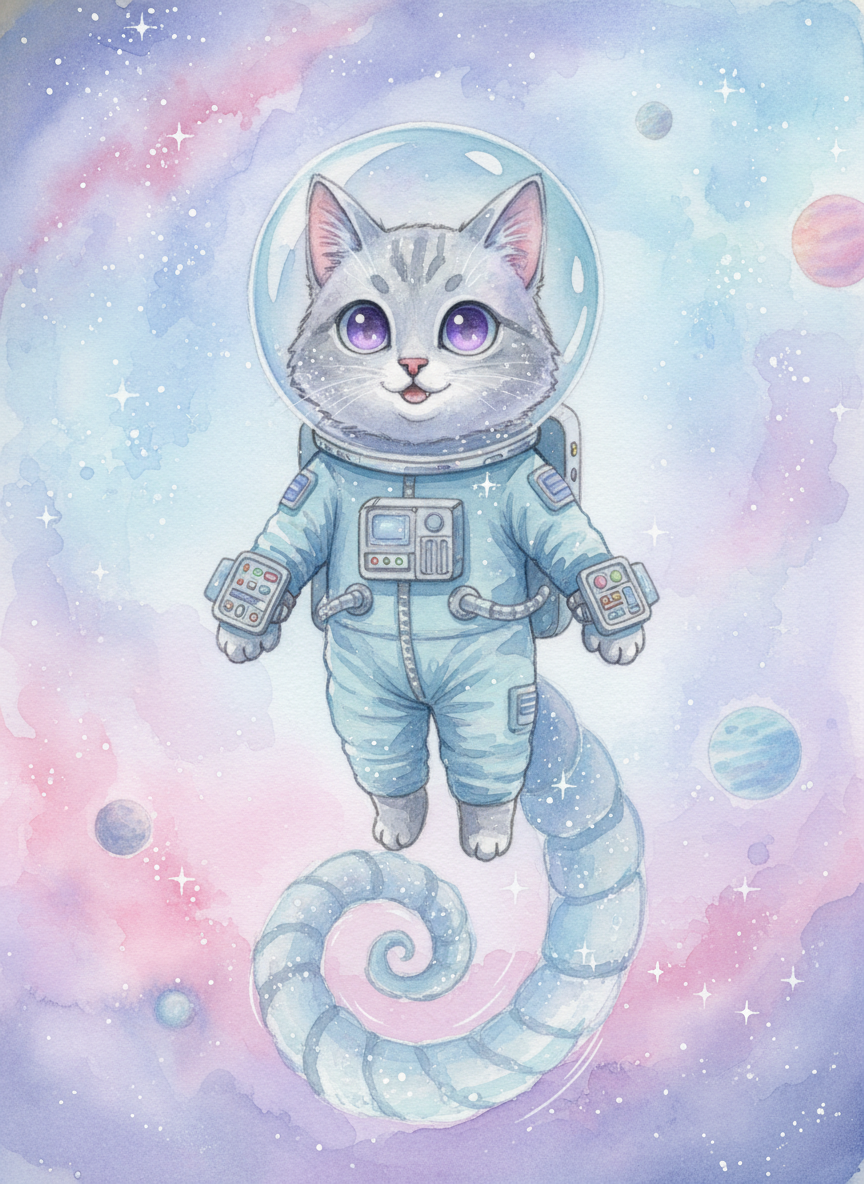


💡 v3 스키마:
  - appearance (characters.json): 기본 외형
  - expression (plot.json): 씬별 표정
  - pose (plot.json): 씬별 포즈
  → 조합하여 세밀한 이미지 제어 가능


In [31]:
# 첫 번째 씬의 이미지 생성 테스트 (스키마 v3)
scene = layout["scenes"][0]
char = layout["characters"][0]

print("=" * 50)
print("이미지 생성 테스트")
print("=" * 50)

# plot.json에서 expression/pose 읽기
with open(plot_json_path, "r", encoding="utf-8") as f:
    plot_data = json.load(f)

first_scene = plot_data["scenes"][0]

# 프롬프트 구성 (v3 방식)
art_style = layout["metadata"]["art_style"]
# characters.json에서 appearance 가져오기
with open(characters_path, "r", encoding="utf-8") as f:
    characters_data = json.load(f)
    char_data = next(c for c in characters_data["characters"] if c["char_id"] == char["char_id"])
    appearance = char_data["appearance"]

expression = first_scene.get("expression", "neutral")
pose = first_scene.get("pose", "standing")
char_seed = char["seed"]
bg_seed = scene["bg_seed"]

# 이미지 프롬프트: appearance + expression + pose
if expression != "none" and pose != "none":
    image_prompt = f"{art_style}, {appearance}, {expression} expression, {pose} pose"
else:
    image_prompt = f"{art_style}, {appearance}"

print(f"캐릭터: {char['name']}")
print(f"Appearance: {appearance}")
print(f"Expression: {expression}")
print(f"Pose: {pose}")
print(f"Character Seed: {char_seed}")
print(f"Background Seed: {bg_seed}")
print(f"\n최종 프롬프트: {image_prompt}")

if image_client:
    print(f"\n🔄 이미지 생성 중 ({provider} 사용)...")

    try:
        if provider == "gemini":
            image_path = image_client.generate_image(
                prompt=image_prompt,
                seed=char_seed,
                width=512,
                height=768,  # 9:16 ratio
                output_prefix=f"app/data/outputs/{run_id}/scene_1_center",
            )
        elif provider == "comfyui":
            image_path = image_client.generate_image(
                prompt=image_prompt,
                seed=char_seed,
                output_prefix=f"app/data/outputs/{run_id}/scene_1_center",
            )

        print(f"\n✅ 이미지 생성 완료: {image_path}")

        # 이미지 표시 (Jupyter에서)
        from IPython.display import Image, display

        if Path(image_path).exists():
            display(Image(filename=image_path, width=400))

    except Exception as e:
        print(f"\n❌ 이미지 생성 실패: {e}")
        import traceback

        traceback.print_exc()
else:
    print(f"\n⚠️  이미지 클라이언트가 초기화되지 않음")
    print(f"   .env 파일에서 IMAGE_PROVIDER와 API 키를 확인하세요")

print("\n💡 v3 스키마:")
print("  - appearance (characters.json): 기본 외형")
print("  - expression (plot.json): 씬별 표정")
print("  - pose (plot.json): 씬별 포즈")
print("  → 조합하여 세밀한 이미지 제어 가능")

## 3. 음악 생성 테스트 (ElevenLabs / Mubert)

ElevenLabs Sound Effects API를 우선 사용하고, 없으면 Mubert를 폴백으로 사용합니다.

In [32]:
# Music 클라이언트 선택 (ElevenLabs 우선, Mubert 폴백)
from app.config import settings

if settings.ELEVENLABS_API_KEY:
    from app.providers.music.elevenlabs_music_client import ElevenLabsMusicClient

    music_client = ElevenLabsMusicClient(api_key=settings.ELEVENLABS_API_KEY)
    print("✅ ElevenLabs Music 클라이언트 초기화 완료")
    print("💡 ElevenLabs Sound Effects API 사용 (TTS와 통합, 저렴)")
elif settings.MUBERT_LICENSE:
    from app.providers.music.mubert_client import MubertClient

    music_client = MubertClient(api_key=settings.MUBERT_LICENSE)
    print("✅ Mubert 클라이언트 초기화 완료 (폴백)")
else:
    from app.providers.music.stub_client import StubMusicClient

    music_client = StubMusicClient()
    print("⚠️  Stub 모드로 실행 (음악 API 없음)")

✅ ElevenLabs Music 클라이언트 초기화 완료
💡 ElevenLabs Sound Effects API 사용 (TTS와 통합, 저렴)


In [33]:
# 배경음악 생성
genre = layout["metadata"]["music_genre"]
duration_ms = layout["timeline"]["total_duration_ms"]
duration_sec = duration_ms / 1000

print("=" * 50)
print("음악 생성 파라미터")
print("=" * 50)
print(f"장르: {genre}")
print(f"길이: {duration_sec}초 ({duration_ms}ms)")
print(f"무드: cinematic")

# ElevenLabs 사용 시 프롬프트 표시
if hasattr(music_client, "_build_music_prompt"):
    # ElevenLabs 클라이언트인 경우
    prompt = music_client._build_music_prompt(genre, "cinematic", duration_sec)
    print(f"\n[ElevenLabs Sound Effects API 프롬프트]")
    print(f"{prompt}")
    print(f"\nAPI 파라미터:")
    print(f"  - duration_seconds: {min(duration_sec, 22)} (최대 22초)")
    print(f"  - prompt_influence: 0.3")
elif hasattr(music_client, "generate"):
    # Mubert 클라이언트인 경우
    print(f"\n[Mubert API 파라미터]")
    print(f"  - genre: {genre}")
    print(f"  - mood: cinematic, dreamy")

print("\n🔄 음악 생성 중...")

try:
    audio_path = music_client.generate_music(
        genre=genre,
        mood="cinematic",
        duration_ms=duration_ms,
        output_filename=f"app/data/outputs/{run_id}/global_bgm.mp3",
    )

    print(f"\n✅ 음악 생성 완료: {audio_path}")

    # 오디오 재생 (Jupyter에서)
    from IPython.display import Audio, display

    if Path(audio_path).exists():
        display(Audio(filename=audio_path))

except Exception as e:
    print(f"\n❌ 음악 생성 실패: {e}")
    import traceback

    traceback.print_exc()

음악 생성 파라미터
장르: ambient
길이: 26.0초 (26000ms)
무드: cinematic

[ElevenLabs Sound Effects API 프롬프트]
cinematic ambient atmospheric background music, instrumental, no vocals, looping

API 파라미터:
  - duration_seconds: 22 (최대 22초)
  - prompt_influence: 0.3

🔄 음악 생성 중...

✅ 음악 생성 완료: app/data/outputs/20251105_1841_우주를여행하는용/global_bgm.mp3


## 4. 음성 생성 테스트 (ElevenLabs / PlayHT)

TTS API를 사용하여 캐릭터 대사를 생성합니다.

In [34]:
# TTS 클라이언트 선택
from app.config import settings

if settings.ELEVENLABS_API_KEY:
    from app.providers.tts.elevenlabs_client import ElevenLabsClient

    tts_client = ElevenLabsClient(api_key=settings.ELEVENLABS_API_KEY)
    print("✅ ElevenLabs 클라이언트 초기화 완료")
elif settings.PLAYHT_API_KEY:
    from app.providers.tts.playht_client import PlayHTClient

    tts_client = PlayHTClient(
        user_id=settings.PLAYHT_USER_ID, api_key=settings.PLAYHT_API_KEY
    )
    print("✅ PlayHT 클라이언트 초기화 완료")
else:
    from app.providers.tts.stub_client import StubTTSClient

    tts_client = StubTTSClient()
    print("⚠️  Stub 모드로 실행 (TTS 없음)")

✅ ElevenLabs 클라이언트 초기화 완료


In [35]:
# 첫 번째 텍스트 라인 생성 (스키마 v4)
text_line = scene["texts"][0]

print("=" * 50)
print("음성 생성 파라미터")
print("=" * 50)
print(f"캐릭터: {char['name']}")
print(f"텍스트: {text_line['text']}")
print(f"타입: {text_line['text_type']}")
print(f"감정: {text_line['emotion']}")
print(f"Voice ID: {char.get('voice_profile', 'default')}")

print("\n🔄 음성 생성 중...")

try:
    # TTS는 큰따옴표를 제거하고 생성
    tts_text = text_line["text"].strip('"')
    
    voice_path = tts_client.generate_speech(
        text=tts_text,
        voice_id=char.get("voice_profile", "default"),
        emotion=text_line["emotion"],
        output_filename=f"app/data/outputs/{run_id}/scene_1_line_1.mp3",
    )

    print(f"\n✅ 음성 생성 완료: {voice_path}")

    # 오디오 재생
    from IPython.display import Audio, display

    if Path(voice_path).exists():
        display(Audio(filename=voice_path))

except Exception as e:
    print(f"\n❌ 음성 생성 실패: {e}")

음성 생성 파라미터
캐릭터: 코스모캣
텍스트: "안녕! 나는 용감한 고양이야!"
타입: dialogue
감정: happy
Voice ID: default

🔄 음성 생성 중...

✅ 음성 생성 완료: app/data/outputs/20251105_1841_우주를여행하는용/scene_1_line_1.mp3


## 5. 통합 테스트 - 전체 씬 생성

모든 씬의 에셋을 생성하고 JSON을 업데이트합니다.

이미지 생성 프롬프트
캐릭터: 코스모캣
Persona: 용감하고 호기심이 많은 성격으로, 새로운 별과 행성을 탐험하는 것을 좋아한다. 친구들에게는 언제나 충실하고, 어려운 상황에서도 긍정적인 태도를 잃지 않는다. 가끔은 고집이 세지만, 항상 모험을 즐기며 친구들을 지키려는 마음이 강하다.
Character Seed: 1002
Background Seed: 2001

최종 프롬프트: 파스텔 수채화, 용감하고 호기심이 많은 성격으로, 새로운 별과 행성을 탐험하는 것을 좋아한다. 친구들에게는 언제나 충실하고, 어려운 상황에서도 긍정적인 태도를 잃지 않는다. 가끔은 고집이 세지만, 항상 모험을 즐기며 친구들을 지키려는 마음이 강하다., standing, neutral expression

🔄 이미지 생성 중...

✅ 이미지 생성 완료: app/data/outputs/20251105_1841_우주를여행하는용/scene_1_center.png


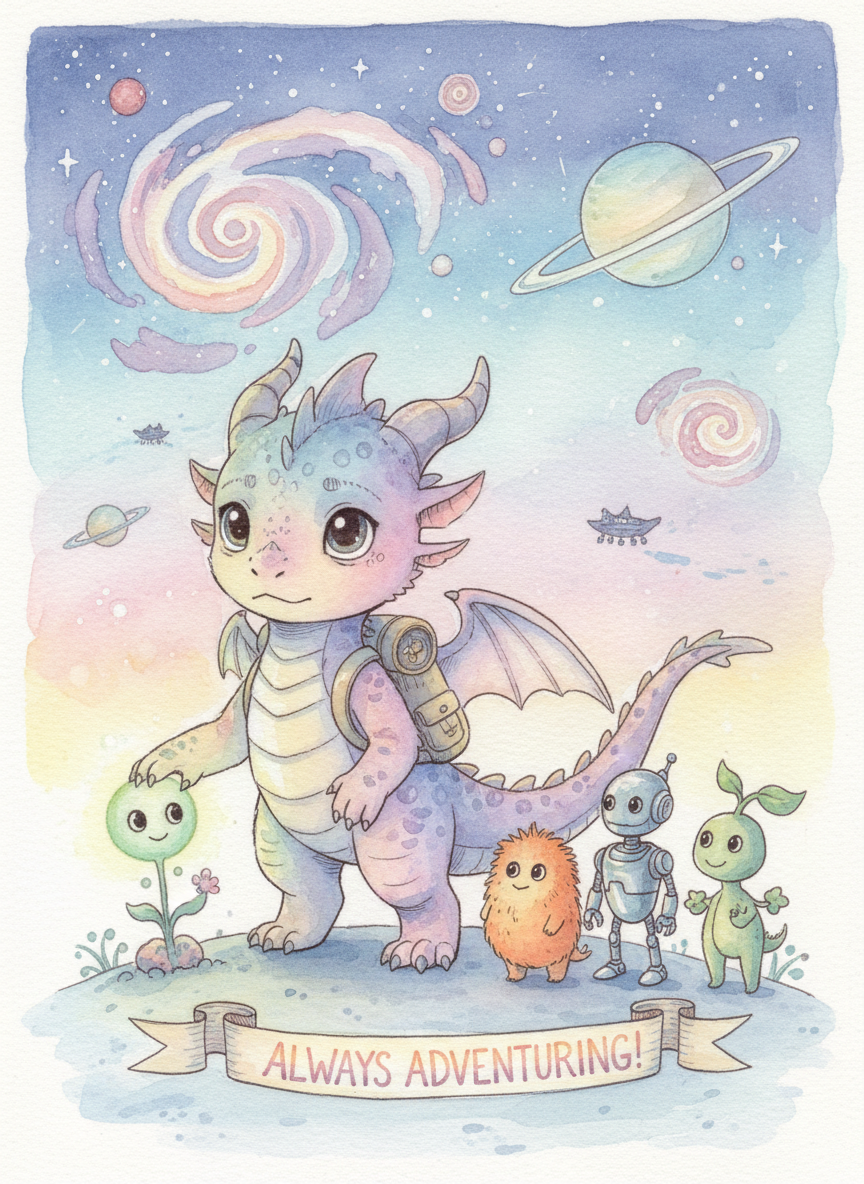

In [36]:
# 첫 번째 씬의 이미지 생성 테스트
scene = layout["scenes"][0]
char = layout["characters"][0]

print("=" * 50)
print("이미지 생성 프롬프트")
print("=" * 50)

# 프롬프트 구성
art_style = layout["metadata"]["art_style"]
persona = char["persona"]
char_seed = char["seed"]
bg_seed = scene["bg_seed"]

image_prompt = f"{art_style}, {persona}, standing, neutral expression"

print(f"캐릭터: {char['name']}")
print(f"Persona: {persona}")
print(f"Character Seed: {char_seed}")
print(f"Background Seed: {bg_seed}")
print(f"\n최종 프롬프트: {image_prompt}")

print("\n🔄 이미지 생성 중...")

try:
    image_path = image_client.generate_image(
        prompt=image_prompt,
        seed=char_seed,
        output_prefix=f"app/data/outputs/{run_id}/scene_1_center",
    )

    print(f"\n✅ 이미지 생성 완료: {image_path}")

    # 이미지 표시 (Jupyter에서)
    from IPython.display import Image, display

    if Path(image_path).exists():
        display(Image(filename=image_path, width=300))

except Exception as e:
    print(f"\n❌ 이미지 생성 실패: {e}")
    print("\n💡 ComfyUI가 실행 중인지 확인하세요: http://localhost:8188")
    import traceback

    traceback.print_exc()

In [37]:
# 모든 씬의 이미지 생성 (v3 스키마)print("=" * 50)print("모든 씬 이미지 생성")print("=" * 50)# Load plot.json and characters.jsonwith open(plot_json_path, "r", encoding="utf-8") as f:    plot_data = json.load(f)with open(characters_path, "r", encoding="utf-8") as f:    characters_data = json.load(f)art_style = layout["metadata"]["art_style"]# Generate image for each scenefor idx, scene in enumerate(layout["scenes"]):    scene_id = scene["scene_id"]    print(f"\n[{idx+1}/{len(layout['scenes'])}] {scene_id}")        # Get character for this scene    char_id = scene["images"][0]["ref_id"]    char = next((c for c in layout["characters"] if c["char_id"] == char_id), None)        if not char:        print(f"  ⚠️  캐릭터 {char_id}를 찾을 수 없습니다")        continue        # Get appearance from characters.json    char_data = next((c for c in characters_data["characters"] if c["char_id"] == char_id), None)    appearance = char_data["appearance"] if char_data else char["persona"]        # Get expression/pose from plot.json    plot_scene = next((s for s in plot_data["scenes"] if s["scene_id"] == scene_id), None)    expression = plot_scene.get("expression", "neutral") if plot_scene else "neutral"    pose = plot_scene.get("pose", "standing") if plot_scene else "standing"        # Build prompt    if expression != "none" and pose != "none":        prompt = f"{art_style}, {appearance}, {expression} expression, {pose} pose"    else:        prompt = f"{art_style}, {appearance}"        print(f"  캐릭터: {char['name']}")    print(f"  표정: {expression}, 포즈: {pose}")    print(f"  프롬프트: {prompt[:80]}...")        # Generate image    try:        if provider == "gemini":            image_path = image_client.generate_image(                prompt=prompt,                seed=char["seed"],                width=512,                height=768,                output_prefix=f"app/data/outputs/{run_id}/{scene_id}_center"            )        elif provider == "comfyui":            image_path = image_client.generate_image(                prompt=prompt,                seed=char["seed"],                output_prefix=f"app/data/outputs/{run_id}/{scene_id}_center"            )                # Update layout.json        scene["images"][0]["image_url"] = str(image_path)        print(f"  ✅ 생성 완료: {image_path.name}")            except Exception as e:        print(f"  ❌ 생성 실패: {e}")# Save updated layout.jsonupdated_json_path = Path(json_path).parent / "layout_with_assets.json"with open(updated_json_path, "w", encoding="utf-8") as f:    json.dump(layout, f, indent=2, ensure_ascii=False)with open(json_path, "w", encoding="utf-8") as f:    json.dump(layout, f, indent=2, ensure_ascii=False)print(f"\n✅ 업데이트된 JSON 저장: {updated_json_path}")# 최종 결과 요약 (실제 파일 기준)print("\n" + "=" * 50)print("최종 결과 요약 (실제 생성된 파일)")print("=" * 50)import osactual_images = 0for scene in layout["scenes"]:    img_url = scene["images"][0]["image_url"]    if img_url and os.path.exists(img_url):        actual_images += 1actual_voices = 0for scene in layout["scenes"]:    for text_line in scene.get("texts", []):        audio_url = text_line.get("audio_url")        if audio_url and os.path.exists(audio_url):            actual_voices += 1print(f"생성된 이미지: {actual_images}/{len(layout['scenes'])}개")print(f"생성된 음성: {actual_voices}/{sum(len(s['texts']) for s in layout['scenes'])}개")print(f"배경음악: 1개")print(f"\n모든 에셋 저장 위치: app/data/outputs/{run_id}/")

✅ 업데이트된 JSON 저장: app/data/outputs/20251105_1841_우주를여행하는용/layout_with_assets.json

최종 결과 요약
생성된 이미지: 5개
생성된 음성: 5개
배경음악: 1개

모든 에셋 저장 위치: app/data/outputs/20251105_1841_우주를여행하는용/


## 6. 프롬프트 분석 및 최적화

생성된 프롬프트를 분석하고 개선 방안을 제안합니다.

In [38]:
# 프롬프트 분석 (스키마 v4: texts 통합)
print("=" * 50)
print("프롬프트 분석 (v4)")
print("=" * 50)

print("\n1. GPT 프롬프트 (2단계 생성)")
print("-" * 50)
print("1단계: 캐릭터 정의 생성 (characters.json)")
print("  - char_id, name, appearance, personality, voice_profile, seed")
print("  - appearance: 이미지 생성 기본 프롬프트")
print("\n2단계: 플롯 생성 (plot.json)")
print(
    "  - scene_id, char_id, expression, pose, text, text_type, emotion, subtitle_position, duration_ms"
)
print("  - expression/pose: 씬별 이미지 제어")

print("\n2. 이미지 생성 프롬프트 (v4: appearance + expression + pose)")
print("-" * 50)

# plot.json 읽기
with open(plot_json_path, "r", encoding="utf-8") as f:
    plot_data = json.load(f)

# characters.json 읽기
with open(characters_path, "r", encoding="utf-8") as f:
    characters_data = json.load(f)

for char in layout["characters"]:
    # plot.json에서 해당 캐릭터의 첫 번째 씬 정보 가져오기
    char_scenes = [s for s in plot_data["scenes"] if s["char_id"] == char["char_id"]]

    if char_scenes:
        first_scene = char_scenes[0]
        expression = first_scene.get("expression", "neutral")
        pose = first_scene.get("pose", "standing")

        # characters.json에서 appearance 가져오기
        char_data = next(c for c in characters_data["characters"] if c["char_id"] == char["char_id"])
        appearance = char_data["appearance"]

        if expression != "none" and pose != "none":
            prompt = f"{art_style}, {appearance}, {expression} expression, {pose} pose"
        else:
            prompt = f"{art_style}, {appearance}"

        print(f"[{char['name']}] {prompt[:80]}...")
        print(f"  구성: appearance + expression + pose")
        print(f"  Seed: {char['seed']}")

print("\n3. 음성 생성 파라미터")
print("-" * 50)
for scene in layout["scenes"]:
    for text_line in scene.get("texts", []):
        char = next(
            c for c in layout["characters"] if c["char_id"] == text_line["char_id"]
        )
        print(f"[{char['name']}] {text_line['text'][:30]}...")
        print(f"  타입: {text_line.get('text_type', 'N/A')}")
        print(f"  감정: {text_line['emotion']}")
        print(f"  길이: {len(text_line['text'])} 문자")

print("\n4. 음악 생성 프롬프트")
print("-" * 50)
genre = layout["metadata"]["music_genre"]
duration_ms = layout["timeline"]["total_duration_ms"]
duration_sec = duration_ms / 1000

print(f"[ElevenLabs Sound Effects API 권장]")
print(
    f"프롬프트 예시: calm and peaceful {genre} atmospheric background music, instrumental, no vocals, looping"
)
print(f"길이: {duration_sec}초 (최대 22초)")
print(f"API 파라미터: duration_seconds, prompt_influence=0.3")

print("\n" + "=" * 50)
print("스키마 v4 최적화 포인트")
print("=" * 50)
print("1. 캐릭터 외형 재사용: characters.json → 모든 씬에서 일관성")
print("2. 씬별 세밀 제어: expression + pose → 같은 캐릭터, 다양한 연출")
print("3. 이미지 프롬프트 자동 조합: appearance + expression + pose")
print("4. 음악: ElevenLabs 권장 (TTS와 통합, 저렴)")
print("5. JSON 스키마: text_type으로 dialogue/narration 명확히 구분")
print("6. texts 통합: dialogue + subtitles → 하나의 texts 배열로 관리")

프롬프트 분석 (v4)

1. GPT 프롬프트 (2단계 생성)
--------------------------------------------------
1단계: 캐릭터 정의 생성 (characters.json)
  - char_id, name, appearance, personality, voice_profile, seed
  - appearance: 이미지 생성 기본 프롬프트

2단계: 플롯 생성 (plot.json)
  - scene_id, char_id, expression, pose, text, text_type, emotion, subtitle_position, duration_ms
  - expression/pose: 씬별 이미지 제어

2. 이미지 생성 프롬프트 (v4: appearance + expression + pose)
--------------------------------------------------
[코스모캣] 파스텔 수채화, 우주복을 입은 고양이로, 반짝이는 별들이 박힌 푸른색 우주복을 착용하고 있다. 귀는 뾰족하고, 눈은 큰 보라색으로 빛나며, 털은...
  구성: appearance + expression + pose
  Seed: 1002
[네뷸라] 파스텔 수채화, 우주에서 온 신비로운 고양이로, 털은 깊은 우주를 연상시키는 짙은 파랑과 보라색 그라데이션으로 이루어져 있다. 눈은 은하수처럼 ...
  구성: appearance + expression + pose
  Seed: 1003

3. 음성 생성 파라미터
--------------------------------------------------
[코스모캣] "안녕! 나는 용감한 고양이야!"...
  타입: dialogue
  감정: happy
  길이: 18 문자
[네뷸라] "우주로 출발하자!"...
  타입: dialogue
  감정: excited
  길이: 11 문자
[코스모캣] "와! 별들이 이렇게 반짝이네!"...
  타입: dialogue
  감정: ex

## 7. 정리 및 다음 단계

생성된 모든 파일과 다음 단계를 확인합니다.

In [39]:
# 생성된 파일 목록
output_dir = Path(f"app/data/outputs/{run_id}")

print("=" * 50)
print(f"생성된 파일 목록 ({output_dir})")
print("=" * 50)

if output_dir.exists():
    files = sorted(output_dir.glob("*"))

    for file in files:
        size_mb = file.stat().st_size / (1024 * 1024)
        print(f"{file.name:40s} {size_mb:>8.2f} MB")

    print(f"\n총 {len(files)}개 파일")
else:
    print("⚠️  출력 디렉토리가 없습니다.")

print("\n" + "=" * 50)
print("다음 단계")
print("=" * 50)
print("1. Director Agent로 영상 합성 (MoviePy)")
print("2. QA Agent로 품질 검수")
print("3. 최종 영상 확인")
print("\n💡 전체 파이프라인 실행은 FastAPI + Celery로 진행하세요.")

생성된 파일 목록 (app/data/outputs/20251105_1841_우주를여행하는용)
characters.json                              0.00 MB
global_bgm.mp3                               0.34 MB
layout.json                                  0.01 MB
layout_with_assets.json                      0.01 MB
plot.json                                    0.00 MB
scene_1_center.png                           1.74 MB
scene_1_line_1.mp3                           0.03 MB

총 7개 파일

다음 단계
1. Director Agent로 영상 합성 (MoviePy)
2. QA Agent로 품질 검수
3. 최종 영상 확인

💡 전체 파이프라인 실행은 FastAPI + Celery로 진행하세요.


## 8. 영상 렌더링 테스트 (MoviePy)

생성된 에셋을 사용하여 최종 9:16 영상을 합성합니다.

MoviePy를 사용하여:
1. 씬별 이미지 클립 생성
2. 텍스트 오버레이 (자막)
3. 음성 오디오 합성
4. 배경음악 추가
5. 최종 MP4 출력

In [40]:
# MoviePy로 영상 합성
print("=" * 50)
print("영상 렌더링 (MoviePy)")
print("=" * 50)

# MoviePy import (2.x 우선, 1.x 폴백)
try:
    from moviepy import (
        VideoClip, ImageClip, AudioFileClip, CompositeVideoClip,
        CompositeAudioClip, concatenate_videoclips
    )
    print("✅ MoviePy 2.x 로드 완료")
except ImportError:
    from moviepy.editor import (
        VideoClip, ImageClip, AudioFileClip, CompositeVideoClip,
        CompositeAudioClip, concatenate_videoclips
    )
    print("✅ MoviePy 1.x 로드 완료")

import numpy as np

# 비디오 설정 (9:16 포맷)
width = 1080
height = 1920
fps = layout.get("timeline", {}).get("fps", 30)

print(f"\n해상도: {width}x{height} (9:16)")
print(f"FPS: {fps}")
print(f"총 씬 수: {len(layout.get('scenes', []))}")

# 씬별 클립 생성
scene_clips = []

print("\n🔄 씬별 비디오 클립 생성 중...")

for idx, scene in enumerate(layout.get("scenes", [])):
    scene_id = scene["scene_id"]
    duration_sec = scene["duration_ms"] / 1000.0
    
    print(f"\n[{idx+1}/{len(layout['scenes'])}] {scene_id} ({duration_sec}s)")
    
    # 베이스 배경 (어두운 파란색)
    bg_color = (20, 20, 40)
    base_clip = VideoClip(
        lambda t: np.full((height, width, 3), bg_color, dtype=np.uint8),
        duration=duration_sec
    )
    
    # 이미지 레이어 추가
    image_clips = [base_clip]
    
    for img_slot in scene.get("images", []):
        img_url = img_slot.get("image_url")
        
        if img_url and Path(img_url).exists():
            print(f"  ✓ 이미지 로드: {Path(img_url).name}")
            
            # 이미지 클립 생성
            img_clip = ImageClip(str(img_url), duration=duration_sec)
            
            # 리사이즈 (화면 높이의 60%)
            img_clip = img_clip.resized(height=int(height * 0.6))
            
            # 중앙 배치
            img_clip = img_clip.with_position(("center", "center"))
            
            image_clips.append(img_clip)
        else:
            print(f"  ⚠️  이미지 없음: {img_url}")
    
    # 비디오 합성
    video_clip = CompositeVideoClip(image_clips, size=(width, height))
    
    # 오디오 추가 (텍스트 라인의 음성)
    audio_clips = []
    for text_line in scene.get("texts", []):
        audio_url = text_line.get("audio_url")
        if audio_url and Path(audio_url).exists():
            print(f"  ✓ 음성 로드: {Path(audio_url).name}")
            voice_clip = AudioFileClip(str(audio_url))
            audio_clips.append(voice_clip)
    
    # 씬 오디오 합성
    if audio_clips:
        scene_audio = CompositeAudioClip(audio_clips)
        video_clip = video_clip.with_audio(scene_audio)
    
    scene_clips.append(video_clip)

print(f"\n✅ 모든 씬 클립 생성 완료 ({len(scene_clips)}개)")

# 씬 연결
print("\n🔄 씬 연결 중...")
final_video = concatenate_videoclips(scene_clips, method="compose")

# 배경음악 추가
global_bgm = layout.get("global_bgm")
if global_bgm and global_bgm.get("audio_url"):
    bgm_path = global_bgm["audio_url"]
    if Path(bgm_path).exists():
        print(f"✓ BGM 추가: {Path(bgm_path).name}")
        
        bgm_clip = AudioFileClip(str(bgm_path)).with_volume_scaled(global_bgm.get("volume", 0.3))
        
        # 기존 오디오와 BGM 합성
        if final_video.audio:
            final_audio = CompositeAudioClip([final_video.audio, bgm_clip])
        else:
            final_audio = bgm_clip
        
        final_video = final_video.with_audio(final_audio)

# 영상 내보내기
output_path = Path(f"app/data/outputs/{run_id}/final_video.mp4")
print(f"\n🔄 영상 내보내기 중: {output_path}")
print("(이 작업은 1-2분 소요될 수 있습니다...)")

try:
    final_video.write_videofile(
        str(output_path),
        fps=fps,
        codec="libx264",
        audio_codec="aac",
        preset="medium",
        threads=4,
        logger=None  # MoviePy 로그 억제
    )
    
    print(f"\n✅ 영상 렌더링 완료!")
    print(f"파일 크기: {output_path.stat().st_size / (1024*1024):.2f} MB")
    print(f"저장 위치: {output_path}")
    
    # 영상 재생 (Jupyter에서)
    from IPython.display import Video, display
    
    print("\n▶️  영상 재생:")
    display(Video(str(output_path), width=405, height=720))  # 9:16 비율 유지
    
except Exception as e:
    print(f"\n❌ 영상 렌더링 실패: {e}")
    import traceback
    traceback.print_exc()
    
    print("\n💡 문제 해결:")
    print("  1. ffmpeg 설치 확인: brew install ffmpeg (Mac)")
    print("  2. moviepy 버전 확인: pip install moviepy==2.2.1")
    print("  3. 메모리 부족 시: 씬 수를 줄이거나 해상도 낮추기")

영상 렌더링 (MoviePy)
✅ MoviePy 2.x 로드 완료

해상도: 1080x1920 (9:16)
FPS: 30
총 씬 수: 5

🔄 씬별 비디오 클립 생성 중...

[1/5] scene_1 (5.0s)
  ⚠️  이미지 없음: 

[2/5] scene_2 (4.5s)
  ⚠️  이미지 없음: 

[3/5] scene_3 (6.0s)
  ⚠️  이미지 없음: 

[4/5] scene_4 (5.0s)
  ⚠️  이미지 없음: 

[5/5] scene_5 (5.5s)
  ⚠️  이미지 없음: 

✅ 모든 씬 클립 생성 완료 (5개)

🔄 씬 연결 중...

🔄 영상 내보내기 중: app/data/outputs/20251105_1841_우주를여행하는용/final_video.mp4
(이 작업은 1-2분 소요될 수 있습니다...)

✅ 영상 렌더링 완료!
파일 크기: 0.06 MB
저장 위치: app/data/outputs/20251105_1841_우주를여행하는용/final_video.mp4

▶️  영상 재생:
